In [13]:
import numpy as np
import pandas as pd 
from concurrent.futures import ThreadPoolExecutor, as_completed
from itertools import product
from openai import OpenAI
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm


In [14]:
tool_df = pd.read_pickle("../data/pkls/ntokens_embeddings_tool_df.pkl")
eval_df = pd.read_pickle("../data/pkls/multiple_tools.pkl")

In [ ]:
eval_df['gt_tool_names'] = eval_df['ground_truth'].apply(lambda x: list(x[0].keys())[0])

# Batch-embed all questions upfront
questions = eval_df['question'].astype(str).tolist()
batch_size = 2048
all_embeddings = []
for i in tqdm(range(0, len(questions), batch_size), desc="Embedding questions"):
    batch = questions[i:i + batch_size]
    response = client.embeddings.create(model="text-embedding-3-large", input=batch)
    all_embeddings.extend([e.embedding for e in response.data])

eval_df['question_embedding'] = all_embeddings

In [ ]:
top_ks = [10]
sample_sizes = [200, 150]
seed = 42
max_workers = 8

In [ ]:
tool_df_dedup = tool_df.drop_duplicates(subset=["name"])

def generate_sample(
    s: int, correct_tools: list[str], tool_df_dedup: pd.DataFrame, rng: np.random.Generator
) -> pd.DataFrame:
    correct_rows = tool_df_dedup.loc[tool_df_dedup["name"].isin(correct_tools)]
    available_df = tool_df_dedup[~tool_df_dedup["name"].isin(correct_tools)]
    random_idx = rng.choice(len(available_df), size=s - len(correct_tools), replace=False)
    sample = available_df.iloc[random_idx]
    return pd.concat([sample, correct_rows])

def evaluate_row(question_embedding, gt_tool_name, tool_df_dedup, s, k, row_seed):
    rng = np.random.default_rng(row_seed)
    sample_df = generate_sample(s, [gt_tool_name], tool_df_dedup, rng)
    filt_df = filter_tools(k, question_embedding, sample_df)
    return gt_tool_name in filt_df["name"].values

In [ ]:
def filter_tools(K: int, question_embedding, sample_df: pd.DataFrame):
    scores = cosine_similarity([question_embedding], np.stack(sample_df['embeddings'].values))
    top_k_idx = np.argsort(scores[0])[-K:][::-1]
    return sample_df.iloc[top_k_idx]

In [ ]:
results = {}
for s, k in product(sample_sizes, top_ks):
    futures = {}
    hits = []

    with ThreadPoolExecutor(max_workers=max_workers) as executor:
        for idx, row in eval_df.iterrows():
            fut = executor.submit(
                evaluate_row,
                row['question_embedding'],
                row['gt_tool_names'],
                tool_df_dedup,
                s, k, seed + idx,
            )
            futures[fut] = idx

        for fut in tqdm(as_completed(futures), total=len(futures), desc=f"S={s}, K={k}"):
            hits.append(fut.result())

    acc = sum(hits) / len(hits) * 100
    results[(s, k)] = acc
    print(f"S={s}, K={k} -> Accuracy: {acc:.2f}% ({sum(hits)}/{len(hits)})\n")

# Summary
print("=" * 40)
for (s, k), acc in results.items():
    print(f"S={s:>4}, K={k:>3} -> {acc:.2f}%")
print("=" * 40)

   175   10     96.30% 
   175   15     96.77% 
   175   20     97.15% 
   125   10     96.68%
   125   15     97.15%
   125   20     97.82%
   150   10     96.39%
   150   15     96.87%
   150   20     97.34%


In [15]:
dataset = {
 "175": {
     "10": 96.30, 
     "15": 96.77, 
     "20": 97.15, 
 },
 "150": {
     "10": 96.39,
     "15": 96.87, 
     "20": 97.34
 }, 
 "125": {
     "10": 96.68,
     "15": 97.15,
     "20": 97.82
 }
}

In [16]:
df = pd.DataFrame(dataset)

In [17]:
df.head()

,175,150,125
10,96.30,96.39,96.68
15,96.77,96.87,97.15
20,97.15,97.34,97.82


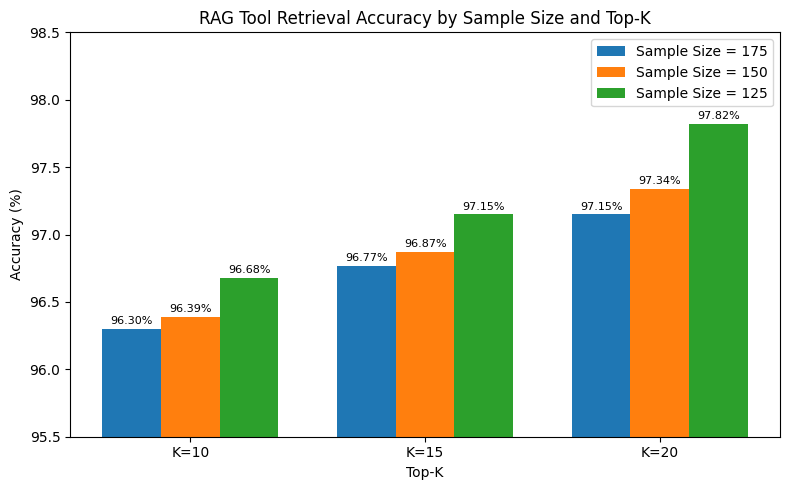

In [18]:
import matplotlib.pyplot as plt

x = np.arange(len(df.index))
width = 0.25

fig, ax = plt.subplots(figsize=(8, 5))

for i, col in enumerate(df.columns):
    bars = ax.bar(x + i * width, df[col], width, label=f"Sample Size = {col}")
    ax.bar_label(bars, fmt="%.2f%%", fontsize=8, padding=2)

ax.set_xlabel("Top-K")
ax.set_ylabel("Accuracy (%)")
ax.set_title("RAG Tool Retrieval Accuracy by Sample Size and Top-K")
ax.set_xticks(x + width)
ax.set_xticklabels([f"K={k}" for k in df.index])
ax.set_ylim(95.5, 98.5)
ax.legend()
plt.tight_layout()
plt.show()